
# Time Series Forecasting using Auto Arima

In [1]:
%matplotlib inline

# Ignore deprecated warning
import warnings
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd
import numpy as np
import datetime
from datetime import datetime, date

# Data visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pylab import rcParams
import scipy
# Set font scale and style
plt.rcParams.update({'font.size': 18})

# Stat models
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
# import custom class
%run -i '../src/helper/ts.py'

In [3]:
# Instantiate the class
fxn = TimeSeriesForecasting()

# Load  data

In [4]:
ts = pd.read_csv('../data/collision_ts_month.csv') # load data
ts.date = pd.to_datetime(ts['date'])  # convert to datetime
ts.index = ts.date # make date the dataframe index
ts = ts.drop(['date'], axis =1)

print("Data size:", ts.shape)
ts.head()

Data size: (228, 9)


,fatality_rate,med_fatal,med_injury,med_no_injury,not-head-on,head-on,year,month,summer_ind
date,,,,,,,,,
1999-01-01,0.013067,85.0,99.0,48.0,108.0,124.0,1999,1,0
1999-02-01,0.017570,101.0,108.0,40.0,93.0,156.0,1999,2,0
1999-03-01,0.021727,105.0,170.0,48.0,96.0,227.0,1999,3,0
1999-04-01,0.013606,99.0,84.0,32.0,44.0,171.0,1999,4,0
1999-05-01,0.018343,150.0,165.0,53.0,79.0,289.0,1999,5,0


##  Create a test  set
We must split the dataset into training and test (out-of-sample) set. We have chosen the test set as the last year's observations (i.e. 2017).


In [5]:
y = ts['fatality_rate']
N = len(y)

exog_variables = list(ts.drop('fatality_rate', axis=1).columns)
X_exog = ts[exog_variables]
X_exog['yearly_seasonality'] = np.arange(N) % 365
X_exog['monthly_seasonality'] = np.arange(N) % 30
# X_exog['weekly_seasonality'] = np.arange(N) % 7

In [6]:
train_start, train_end = '1999-01-01','2016-12-01'
test_start, test_end = '2017-01-01', '2017-12-01'

X_train = X_exog[train_start: train_end]
y_train = y[train_start: train_end]

X_test = X_exog[test_start: test_end]
y_test = y[test_start: test_end]

## Normalization

In [7]:
# Standardization
scaler_y = StandardScaler() 
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1)) 

# Normalization 
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# pandas dataframe
X_train_df = pd.DataFrame(X_train_scaled, columns = X_train.columns)
X_test_df = pd.DataFrame(X_test_scaled, columns = X_test.columns)

## SARIMAX
We build Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors (SARIMAX) model using pmdarima‘s auto_arima(). We set seasonal = True, the frequency m = 12 for monthly time series, and seasonal differencing D = 1.

In [8]:
# Train sarimax from auto arima API
sarimax = pm.auto_arima(y_train_scaled, exogenous = X_train_df, max_p = 4, max_q = 4, D = 1, 
                 m=12, test = 'adf', stepwise=True, suppress_warnings=True, error_action='ignore',                  seasonal= True, random_state= 42, trace = True, n_fits= 20)
sarimax.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=187.993, Time=0.37 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=549.833, Time=2.49 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=228.366, Time=1.58 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1067.942, Time=0.29 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=527943.942, Time=4.99 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=224.194, Time=3.05 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=155958.377, Time=1.97 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=637072.246, Time=1.16 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=40088.782, Time=1.03 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=3253858.335, Time=1.46 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12] intercept
Total fit time: 24.850 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                  216
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                 -81.996
Date:                  Thu, 07 Apr 2022   AIC                            187.993
Time:                          08:14:27   BIC                            227.810
Sample:                               0   HQIC                           204.100
                                  - 216                                         
Covariance Type:                    opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
intercept            7.529e-05      0.027      0.003      0.998      -0.053       0.054
med_fatal            4.935e+08      0.279   1.77e+09      0.000    4.93e+08    4.93e+08
med_injury           7.297e+08      0.233   3.13e+09      0.000     7.3e+08     7.3e+08
med_no_injury        2.811e+08      0.163   1.72e+09      0.000    2.81e+08    2.81e+08
not-head-on         -5.024e+08      0.137  -3.67e+09      0.000   -5.02e+08   -5.02e+08
head-on             -1.229e+09      0.112   -1.1e+10      0.000   -1.23e+09   -1.23e+09
year                -5.976e+12      0.002  -3.73e+15      0.000   -5.98e+12   -5.98e+12
month                  -0.0178   3.13e-18  -5.69e+15      0.000      -0.018      -0.018
summer_ind              0.0010    1.7e-18   5.68e+14      0.000       0.001       0.001
yearly_seasonality   6.298e+12      0.002   4.14e+15      0.000     6.3e+12     6.3e+12
monthly_seasonality    -0.0799      0.056     -1.439      0.150      -0.189       0.029
sigma2                  0.1308      0.013     10.350      0.000       0.106       0.156
===================================================================================
Ljung-Box (L1) (Q):                  29.44   Jarque-Bera (JB):                 4.02
Prob(Q):                              0.00   Prob(JB):                         0.13
Heteroskedasticity (H):               0.90   Skew:                            -0.26
Prob(H) (two-sided):                  0.66   Kurtosis:                         3.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.57e+35. Standard errors may be unstable.
"""

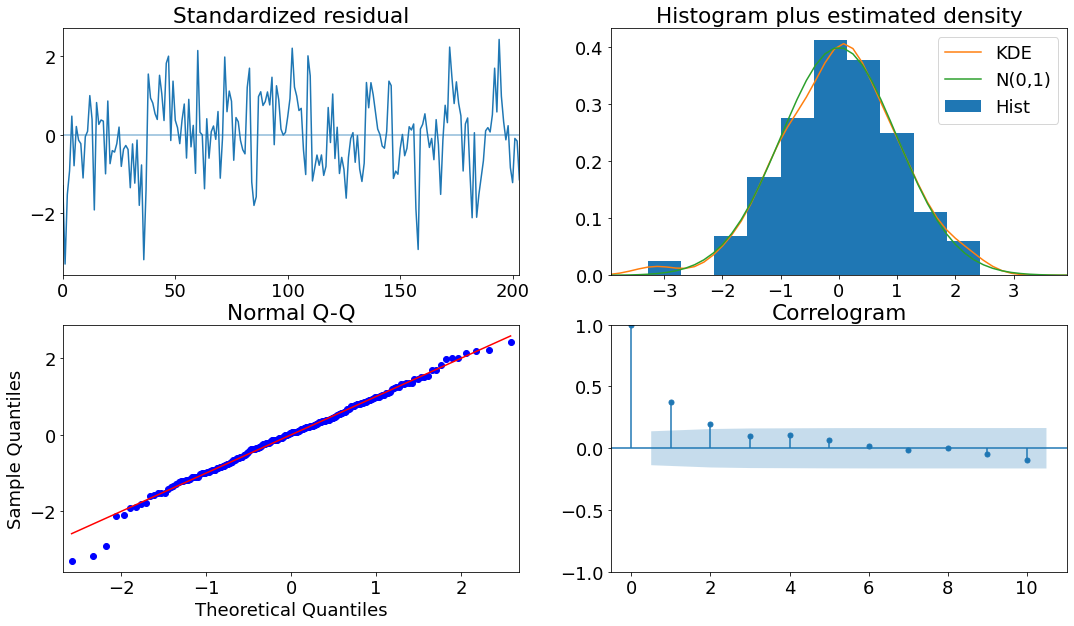

In [9]:
sarimax.plot_diagnostics(figsize=(18,10))
plt.show()

## Test (out-of-sample) prediction

In [10]:
y_pred, conf_int = sarimax.predict(n_periods = len(y_test), exogenous=X_test_df, return_conf_int=True)
y_pred = scaler_y.inverse_transform(y_pred.reshape(-1,1)).flatten() # Inverse transform scale

## Performance measures (error metrics)

In [11]:
fxn.error_metrics(y_test, y_pred)

{'MAE = 0.001', 'MAPE = 5.933', 'RMSE = 0.001', 'R^2 = 0.909', 'WMAPE = 5.502'}

In [12]:
y_pred[y_pred<0] = 0

y_low = conf_int[:,0]
y_low = scaler_y.inverse_transform(y_low.reshape(-1,1)).flatten()
y_high = conf_int[:,1]
y_high = scaler_y.inverse_transform(y_high.reshape(-1,1)).flatten()

results = pd.DataFrame()
results['y_pred'] = y_pred
results['y_low'] = y_low
results['y_high'] = y_high
results.index = y_test.index

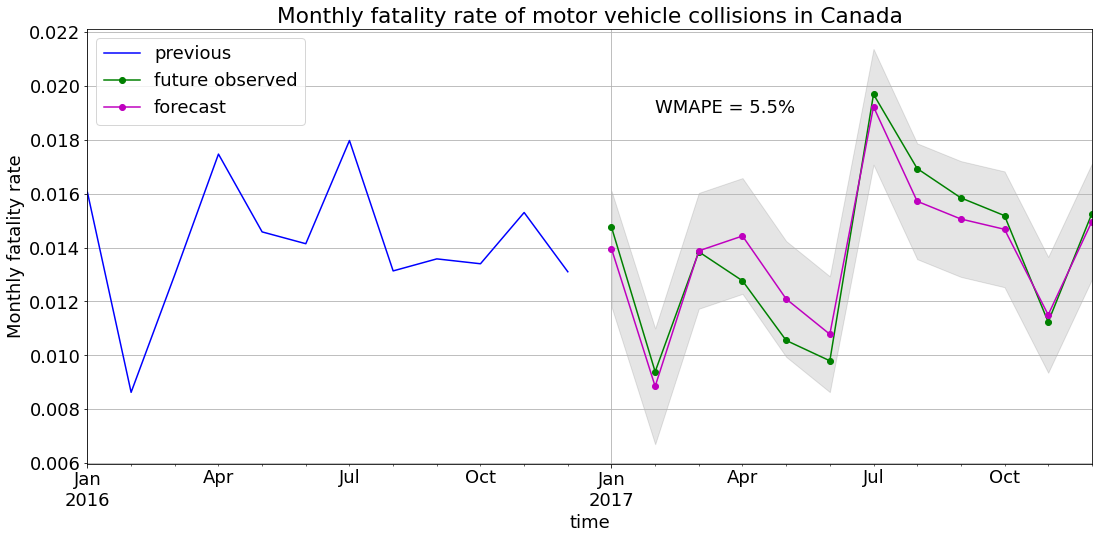

In [24]:
plt.figure(figsize = (18,8))

y_train.iloc[-len(y_test):].plot(label = 'previous', color = 'b')
y_test.plot(label = 'future observed', marker = 'o', color = 'g')
results['y_pred'].plot(label = 'forecast', marker = 'o', color = 'm')

plt.fill_between(results.index, results['y_low'], results['y_high'], color='k', alpha=0.1)
plt.xlabel('time')
plt.text('2017-02-01', 0.019, "WMAPE = 5.5%")
plt.grid(True)
plt.ylabel('Monthly fatality rate')
plt.title('Monthly fatality rate of motor vehicle collisions in Canada')
plt.legend()
plt.savefig('../images/fig.png')
plt.show()

## Test set error

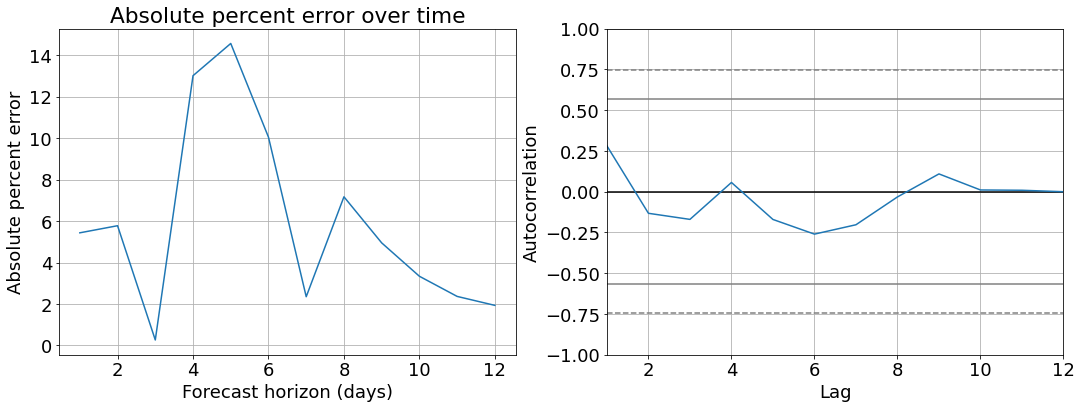

In [14]:
plt.figure(figsize = (18,6))
abs_err = 100*np.abs((y_pred - y_test.values)/(y_test.values))

plt.subplot(121)
plt.plot(np.arange(1, len(abs_err)+1), abs_err)
plt.grid(True)
plt.xlabel('Forecast horizon (days)')
plt.ylabel('Absolute percent error')
plt.title('Absolute percent error over time')

plt.subplot(122)
pm.autocorr_plot(abs_err)
plt.show()

In [15]:
# plt.figure(figsize = (8,6))
# abs_err = 100*np.abs((y_pred - y_test.values)/(y_test.values))

# plt.plot(acorr_ljungbox(abs_err, lags = 11)[0], 'o')
# plt.axhline(y=0.05,linestyle= '--', color = 'k')
# plt.ylabel('p-value', fontsize = 20)
# plt.xlabel('Lag', fontsize = 20)
# plt.title('p-values for Ljung-Box statistic', fontsize = 20)